# Preprocessing the data of scRNA-seq with omicverse

The count table, a numeric matrix of genes × cells, is the basic input data structure in the analysis of single-cell RNA-sequencing data. A common preprocessing step is to adjust the counts for variable sampling efficiency and to transform them so that the variance is similar across the dynamic range. 

Suitable methods to preprocess the scRNA-seq is important. Here, we introduce some preprocessing step to help researchers can perform downstream analysis easyier.

User can compare our tutorial with [scanpy'tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) to learn how to use omicverse well

Colab_Reproducibility：https://colab.research.google.com/drive/18a6vsvdRdWVPCP-KSaiznou7PBVtNVXw?usp=sharing

In [1]:
import omicverse as ov
from omicverse.utils import mde
import scanpy as sc
import scvelo as scv
ov.utils.ov_plot_set()


/Users/fernandozeng/miniforge3/envs/scbasset/lib/python3.8/site-packages/phate/__init__.py
/Users/fernandozeng/miniforge3/envs/scbasset/lib/python3.8/site-packages/phate/__init__.py


The data consist of 3k PBMCs from a Healthy Donor and are freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.

In [ ]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

In [2]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading
adata

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Preprocessing

### Quantity control

For single-cell data, we require quality control prior to analysis, including the removal of cells containing double cells, low-expressing cells, and low-expressing genes. In addition to this, we need to filter based on mitochondrial gene ratios, number of transcripts, number of genes expressed per cell, cellular Complexity, etc. For a detailed description of the different QCs please see the document: https://hbctraining.github.io/scRNA-seq/lessons/04_SC_quality_control.html

In [3]:
adata=ov.pp.qc(adata,
              tresh={'mito_perc': 0.05, 'nUMIs': 500, 'detected_genes': 250})
adata

Calculate QC metrics
End calculation of QC metrics.
Original cell number: 2700
Begin of post doublets removal and QC plot
Running Scrublet
filtered out 19024 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.31
Detected doublet rate = 1.4%
Estimated detectable doublet fraction = 35.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.0%
    Scrublet finished (0:00:01)
Cells retained after scrublet: 2662, 38 removed.
End of post doublets removal and QC plots.
Filters application (seurat or mads)
Lower tresh

AnnData object with n_obs × n_vars = 2603 × 13631
    obs: 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells'
    uns: 'scrublet'

### High variable Gene Detection

Here we try to use Pearson's method to calculate highly variable genes. This is the method that is proposed to be superior to ordinary normalisation. See [Article](https://www.nature.com/articles/s41592-023-01814-1#MOESM3) in *Nature Method* for details.

We can set `mode` between `scanpy` and `pearson` to perform HVG analysis. Besides, if you want to remove cell cycle genes, you can set `no_cc=False` and `organism=mouse/human`。

- if you use `mode`=`scanpy` you need to set `target_sum=50*1e4`, more people like to se `target_sum=1e4`, we test the result think 50*1e4 will be better
- if you use `mode`=`pearson`, you don't need to set `target_sum`

In [4]:
adata=ov.pp.preprocess(adata,mode='pearson',n_HVGs=2000,)
adata

Begin log-normalization, HVGs identification
After filtration, 13631/13631 genes are kept. Among 13631 genes, 13631 genes are robust.
End of log-normalization, HVGs identification.
Begin size normalization and pegasus batch aware HVGs selection or Perason residuals workflow
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
computing analytic Pearson residuals on adata.X
    finished (0:00:00)
End of size normalization and pegasus batch aware HVGs selection or Perason residuals workflow.


AnnData object with n_obs × n_vars = 2603 × 13631
    obs: 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'hvg', 'pearson_residuals_normalization'

Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

In [5]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]
adata

View of AnnData object with n_obs × n_vars = 2603 × 2000
    obs: 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'hvg', 'pearson_residuals_normalization'

## Principal component analysis

In contrast to scanpy, we do not directly scale the variance of the original expression matrix, but store the results of the variance scaling in the layer, due to the fact that scale may cause changes in the data distribution, and we have not found scale to be meaningful in any scenario other than a principal component analysis

In [6]:
adata=ov.pp._preprocess.scale(adata)
adata

AnnData object with n_obs × n_vars = 2603 × 2000
    obs: 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'hvg', 'pearson_residuals_normalization'
    layers: 'scaled'

If you want to perform pca in normlog layer, you can set `layer`=`normlog`, but we think scaled is necessary in PCA.

In [7]:
adata=ov.pp.pca(adata,layer='scaled',n_pcs=50)
adata

AnnData object with n_obs × n_vars = 2603 × 2000
    obs: 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'hvg', 'pearson_residuals_normalization', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'

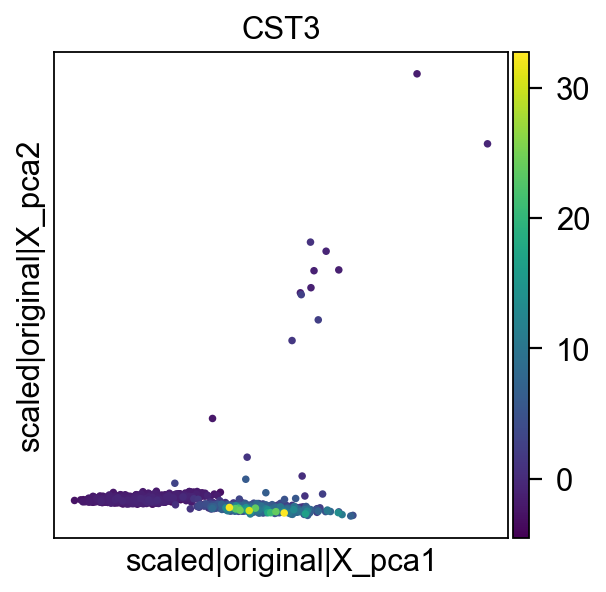

In [8]:
sc.pl.embedding(adata,
                basis='scaled|original|X_pca',
                color='CST3')

## Embedding the neighborhood graph

We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

In [9]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50,
               use_rep='scaled|original|X_pca')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


To visualize the PCA’s embeddings, we use the `pymde` package wrapper in omicverse. This is an alternative to UMAP that is GPU-accelerated.

In [10]:
from omicverse.utils import mde
adata.obsm["X_mde"] = mde(adata.obsm["scaled|original|X_pca"])
adata

AnnData object with n_obs × n_vars = 2603 × 2000
    obs: 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'hvg', 'pearson_residuals_normalization', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'neighbors'
    obsm: 'scaled|original|X_pca', 'X_mde'
    varm: 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'
    obsp: 'distances', 'connectivities'

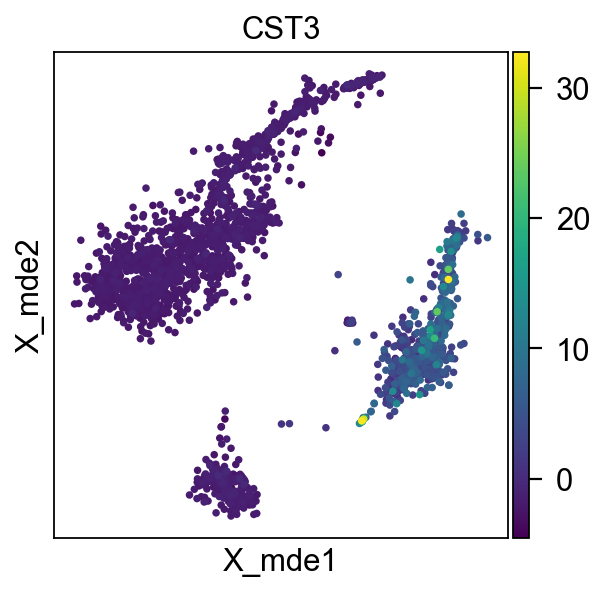

In [11]:
sc.pl.embedding(adata,
                basis='X_mde',
                color='CST3')

You also can use `umap` to visualize the neighborhood graph

In [12]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


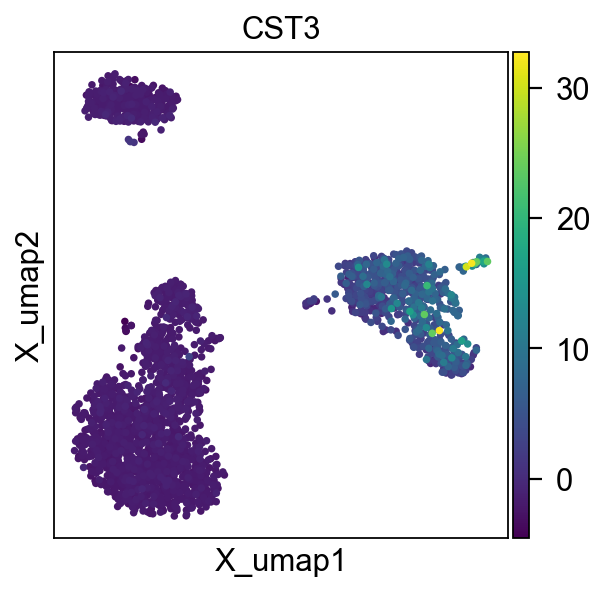

In [13]:
sc.pl.embedding(adata,
                basis='X_umap',
                color='CST3')

## Clustering the neighborhood graph

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by Traag *et al.* (2018). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [14]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


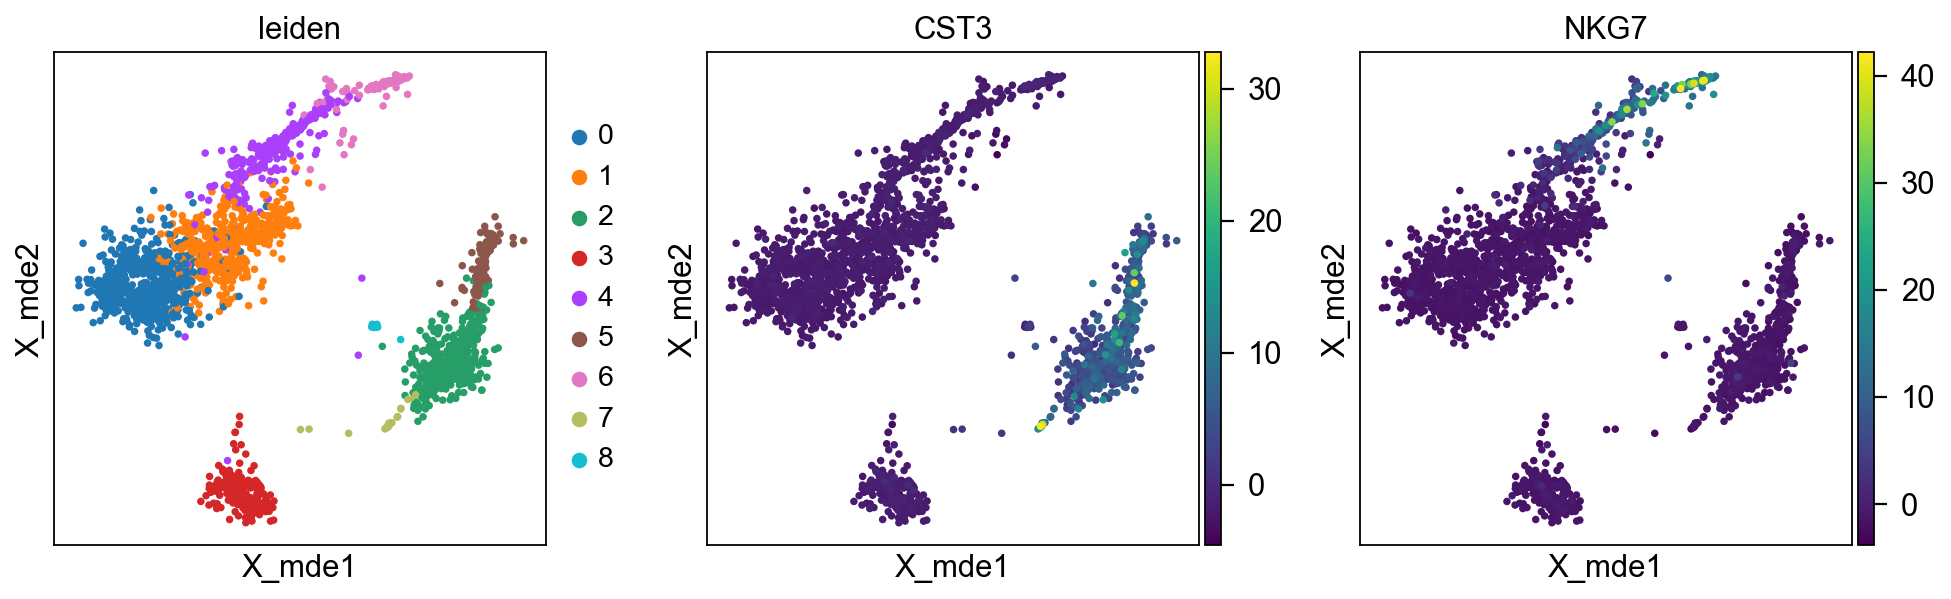

In [15]:
sc.pl.embedding(adata,
                basis='X_mde',
                color=['leiden', 'CST3', 'NKG7'])

In [16]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

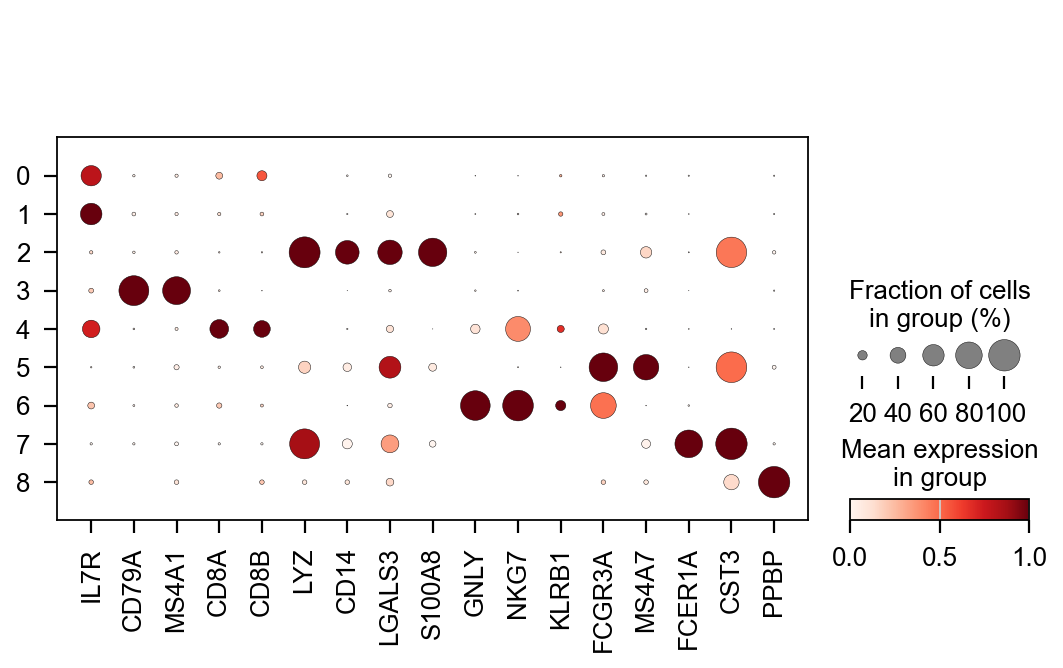

In [17]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden',
             standard_scale='var');